# Построение модели по определению рыночной стоимости автомобиля для сервиса «Не бит, не крашен»

## Цели исследования

- Разработать несколько моделей МО для сервиса «Не бит, не крашен» для определения рыночной стоимости автомобиля.


- Проанализировать полученные результаты и отобрать удовлетворяющую запросам заказчика модель.


## Ход исследования

- Загрузка предоставленных нам данных и первичное ознакомление с ними.


- Обработка пропусков и дубликатов в данных , а так же поиск аномалий и улучшение качества данных.


- Проведение анализа данных, с целью установления информативности признаков.


- Создание *классических* моделей и модели градиентного бустинга с целью сравнения результатов.


- Анализ полученных результатов работы моделей.


- Проверка выбранной модели на тестовых данных.


- Итоговый вывод и описание проделанной работы.


## Описание переменных представленных в данных

- **DateCrawled** — дата скачивания анкеты из базы  
- **VehicleType** — тип автомобильного кузова  
- **RegistrationYear** — год регистрации автомобиля  
- **Gearbox** — тип коробки передач  
- **Power** — мощность (л. с.)  
- **Model** — модель автомобиля  
- **Kilometer** — пробег (км)  
- **RegistrationMonth** — месяц регистрации автомобиля  
- **FuelType** — тип топлива  
- **Brand** — марка автомобиля  
- **Repaired** — была машина в ремонте или нет  
- **DateCreated** — дата создания анкеты  
- **NumberOfPictures** — количество фотографий автомобиля  
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)  
- **LastSeen** — дата последней активности пользователя  
- **Price** — цена (евро)


## Техническая секция

### Импорт библиотек.

In [1]:
import math
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shap
import phik
import warnings
import time
import joblib
import math
from lightgbm import LGBMRegressor
from category_encoders import CatBoostEncoder
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder
from sklearn.metrics import (r2_score, 
                             mean_squared_error, 
                             mean_absolute_error, 
                             accuracy_score, precision_score,
                             recall_score, 
                             confusion_matrix, 
                             precision_recall_curve, 
                             classification_report, 
                             roc_auc_score, 
                             make_scorer, 
                             f1_score)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Определение функций.

In [2]:
RS = 42
%matplotlib inline 

In [3]:
def power_change(row):
    """Изменяет порядок числа в зависимости от его величины.
    
    Правила преобразования:
    - Если число в диапазоне [1000, 10000), делит на 10 (уменьшает порядок на 1).
    - Если число в диапазоне [10000, 20000], делит на 100 (уменьшает порядок на 2).
    - В остальных случаях возвращает число без изменений.

    Args:
        row (int): Входное число для преобразования.

    Returns:
        int: Преобразованное число согласно заданным правилам.

    Examples:
        >>> power_change(5000)
        500
        >>> power_change(15000)
        150
        >>> power_change(500)
        500
    """
    if 1000 <= row < 10000:
        return row // 10
    elif 10000 <= row <= 20000:
        return row // 100
    else:
        return row

In [4]:
def graph_num(df, columns, title, xlabel, bins=30):
    """
    Визуализирует числовые данные с помощью гистограммы и boxplot.

    Параметры:
    -----------
    df : pandas.DataFrame
        DataFrame, содержащий данные для анализа.
    columns : str
        Название столбца с числовыми данными, которые будут визуализированы.
    title : str
        Заголовок графика (добавляется к описанию гистограммы и boxplot).
    xlabel : str
        Подпись оси X для гистограммы.
    bins : int, optional
        Количество интервалов (бинов) для гистограммы. По умолчанию 30.

    
    """
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.histplot(data=df, x=columns, kde=True, color='blue', bins=bins, ax=ax[0])
    ax[0].set_title('Гистограмма признака '+ title)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Кол-во')
    
    sns.boxplot(data=df[columns], orient='h', ax=ax[1])
    ax[1].set_title('Разброс значений признака '+ title)
    ax[1].set_xlabel('Значения')
    ax[1].set_ylabel(' ')

In [5]:
def check_data_dubmiss(df, df_name='DataFrame'):
    """
    Анализирует DataFrame на дубликаты и пропущенные значения.
    Возвращает единый отчет в виде DataFrame с категориями.

    Параметры:
    - df: pandas DataFrame для проверки
    - df_name: название DataFrame для отчета

    Возвращает:
    - Единый DataFrame с отчетом
    """
    report_parts = []

    # 1. Общая информация
    info_df = pd.DataFrame({
        'Категория': ['Общая информация'],
        'Параметр': ['Название датафрейма'],
        'Значение': [df_name],
        'Детали': [f'Размер : {df.shape[0]} x {df.shape[1]}']
    })
    report_parts.append(info_df)

    # 2. Дубликаты
    duplicates = df.duplicated().sum()
    duplicates_df = pd.DataFrame({
        'Категория': ['Дубликаты', 'Дубликаты'],
        'Параметр': ['Всего дубликатов', 'Примеры дубликатов'],
        'Значение': [duplicates, duplicates > 0],
        'Детали': ['', f"Первые {min(5, duplicates)} примеров" if duplicates > 0 else '']
    })
    report_parts.append(duplicates_df)

    # 3. Пропущенные значения по столбцам
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    if missing.sum() > 0:
        missing_df = pd.DataFrame({
            'Категория': ['Пропущенные значения'] * len(missing),
            'Параметр': missing.index,
            'Значение': missing.values,
            'Детали': [f"{pct:.2f}%" for pct in missing_pct.values]
        })
        missing_df = missing_df[missing_df['Значение'] > 0]
        report_parts.append(missing_df)

    # 4. Итог по пропущенным значениям
    total_missing_df = pd.DataFrame({
        'Категория': ['Пропуски'],
        'Параметр': ['Всего пропущенных значений'],
        'Значение': [missing.sum()],
        'Детали': [f"{missing.sum() / df.size:.2%} от всех ячеек"]
    })
    report_parts.append(total_missing_df)

    report = pd.concat(report_parts, ignore_index=True)

    if duplicates > 0:
        duplicates_examples = df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head()
        report.at[4, 'Детали'] = str(duplicates_examples.to_dict('records'))

    return report

## Загрузка полученных данных.

In [6]:
try :
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')


### Первичное ознакомление с данными.

In [7]:
display(df.head(5))
display(df.describe().T)
display(df.info())

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand Repaired  \
0   golf     150000                  0    petrol  volkswagen      NaN   
1    NaN     125000                  5  gasoline        audi      yes   
2  grand     125000                  8  gasoline        jeep      NaN   
3   golf     150000                  6    petrol  volkswagen       no   
4  fabia      90000                  7  gasoline       skoda       no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

count           mean           std     min       25%  \
Price              354369.0    4416.656776   4514.158514     0.0    1050.0   
RegistrationYear   354369.0    2004.234448     90.227958  1000.0    1999.0   
Power              354369.0     110.094337    189.850405     0.0      69.0   
Kilometer          354369.0  128211.172535  37905.341530  5000.0  125000.0   
RegistrationMonth  354369.0       5.714645      3.726421     0.0       3.0   
NumberOfPictures   354369.0       0.000000      0.000000     0.0       0.0   
PostalCode         354369.0   50508.689087  25783.096248  1067.0   30165.0   

                        50%       75%       max  
Price                2700.0    6400.0   20000.0  
RegistrationYear     2003.0    2008.0    9999.0  
Power                 105.0     143.0   20000.0  
Kilometer          150000.0  150000.0  150000.0  
RegistrationMonth       6.0       9.0      12.0  
NumberOfPictures        0.0       0.0       0.0  
PostalCode          49413.0   71083.0   99998.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [8]:
ProfileReport(df, title="Profiling Report", minimal=False, progress_bar=False)

100%|██████████| 16/16 [00:04<00:00,  3.30it/s]


### Вывод

Мы выполнили загрузку присланных заказчиком данных.  

Проведя первичное ознакомление, обнаружили следующие дефекты в данных:

**Основные проблемы:**
- **`NumberOfPictures`** представлен всего одним значением и не имеет никакой ценности для обучения моделей.  
- **Пропуски** в следующих признаках:  
  - `VehicleType`  
  - `Gearbox`  
  - `Model`  
  - `FuelType`  
  - `Repaired`  
- **Нулевые значения** в переменных:  
  - `Price`  
  - `Power`  
  - `RegistrationMonth`  
- **Аномальные значения** в столбцах:  
  - `RegistrationYear`  
  - `Power`  
- **Незначительные дубликаты** в количестве: **4**.  

Стратегию по улучшению каждого из признаков рассмотрим в блоке предобработки.

## Предобработка данных и фильтрация признаков.

Для дальнейшего удобства , приведем названия столбцов к общепринятому стандарту.

In [9]:
df.columns = (df.columns.str.lower())

In [10]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Создадим копию датафрейма для контроля размерности при обработке данных.

In [11]:
check = df.copy()

### Обработка дубликатов.

На этапе ознакомления с данными , были обнаружены незначительные дубликаты , ознакомимся с данной проблемой подробней.

In [12]:
check_data_dubmiss(df)

Категория                    Параметр   Значение  \
0      Общая информация         Название датафрейма  DataFrame   
1             Дубликаты            Всего дубликатов          4   
2             Дубликаты          Примеры дубликатов       True   
3  Пропущенные значения                 vehicletype      37490   
4  Пропущенные значения                     gearbox      19833   
5  Пропущенные значения                       model      19705   
6  Пропущенные значения                    fueltype      32895   
7  Пропущенные значения                    repaired      71154   
8              Пропуски  Всего пропущенных значений     181077   

                                              Детали  
0                               Размер : 354369 x 16  
1                                                     
2                                  Первые 4 примеров  
3                                             10.58%  
4  [{'datecrawled': '2016-03-08 18:42:48', 'price...  
5                                              5.56%  
6                                              9.28%  
7                                             20.08%  
8                                3.19% от всех ячеек

In [13]:
df[df.duplicated(keep=False)]

datecrawled  price vehicletype  registrationyear gearbox  \
41529   2016-03-18 18:46:15   1999       wagon              2001  manual   
88087   2016-03-08 18:42:48   1799       coupe              1999    auto   
90964   2016-03-28 00:56:10   1000       small              2002  manual   
171088  2016-03-08 18:42:48   1799       coupe              1999    auto   
187735  2016-04-03 09:01:15   4699       coupe              2003    auto   
231258  2016-03-28 00:56:10   1000       small              2002  manual   
258109  2016-04-03 09:01:15   4699       coupe              2003    auto   
325651  2016-03-18 18:46:15   1999       wagon              2001  manual   

        power   model  kilometer  registrationmonth  fueltype          brand  \
41529     131  passat     150000                  7  gasoline     volkswagen   
88087     193     clk      20000                  7    petrol  mercedes_benz   
90964      83   other     150000                  1    petrol         suzuki   
171088    193     clk      20000                  7    petrol  mercedes_benz   
187735    218     clk     125000                  6    petrol  mercedes_benz   
231258     83   other     150000                  1    petrol         suzuki   
258109    218     clk     125000                  6    petrol  mercedes_benz   
325651    131  passat     150000                  7  gasoline     volkswagen   

       repaired          datecreated  numberofpictures  postalcode  \
41529        no  2016-03-18 00:00:00                 0       36391   
88087        no  2016-03-08 00:00:00                 0       89518   
90964        no  2016-03-28 00:00:00                 0       66589   
171088       no  2016-03-08 00:00:00                 0       89518   
187735      yes  2016-04-03 00:00:00                 0       75196   
231258       no  2016-03-28 00:00:00                 0       66589   
258109      yes  2016-04-03 00:00:00                 0       75196   
325651       no  2016-03-18 00:00:00                 0       36391   

                   lastseen  
41529   2016-03-18 18:46:15  
88087   2016-03-09 09:46:57  
90964   2016-03-28 08:46:21  
171088  2016-03-09 09:46:57  
187735  2016-04-07 09:44:54  
231258  2016-03-28 08:46:21  
258109  2016-04-07 09:44:54  
325651  2016-03-18 18:46:15

Удалим повторяющиеся строки , оставив в данных первое появление дублирующих значений.

In [14]:
df = df.drop_duplicates(keep='first')

In [15]:
print(f'Размерность базового датасета : {len(check)}')
print(f'Размерность датасета после обработки : {len(df)}')

Размерность базового датасета : 354369
Размерность датасета после обработки : 354365


### Date

Преобразуем типы данных с датой , для того что бы определится к какому временному периоду относятся наши данные.

In [16]:
df[['datecrawled', 'datecreated', 'lastseen']] = df[['datecrawled', 'datecreated', 'lastseen']].apply(pd.to_datetime)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)


C:\Users\para\AppData\Local\Temp\ipykernel_19824\1075240215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['datecrawled', 'datecreated', 'lastseen']] = df[['datecrawled', 'datecreated', 'lastseen']].apply(pd.to_datetime)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        316875 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            334532 non-null  object        
 5   power              354365 non-null  int64         
 6   model              334660 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           321470 non-null  object        
 10  brand              354365 non-null  object        
 11  repaired           283211 non-null  object        
 12  datecreated        354365 non-null  datetime64[ns]
 13  numberofpictures   354365 non-null  int64        

In [18]:
display(df['datecrawled'].dt.year.value_counts())
display(df['datecreated'].dt.year.value_counts())
df['lastseen'].dt.year.value_counts() 

datecrawled
2016    354365
Name: count, dtype: int64

datecreated
2016    354339
2015        25
2014         1
Name: count, dtype: int64

lastseen
2016    354365
Name: count, dtype: int64

Видим что данные представляют собой выгрузку за **2016** год.

Так же проведем проверку за весь ли год прошла выгрузка , проверив кол-во месяцев.

In [19]:
display(df['datecreated'].dt.month.value_counts().sort_index(ascending=True))

datecreated
1         70
2        397
3     296756
4      57118
6          1
8          2
9          3
11         9
12         9
Name: count, dtype: int64

Видим что **2016** год представлен полностью.

### Model

Так как модель машины оказывает доминирующее влияние на цену автомобиля , избавимся от мусорных данных где не известна марка машины и цена.

In [20]:
trash = df[(df.model.isna()) & (df.price == 0)]
print(f'Размерность среза : {len(trash)}')
trash.head(10)

Размерность среза : 2184


datecrawled  price vehicletype  registrationyear gearbox  power  \
115  2016-03-20 18:53:27      0       small              1999     NaN      0   
478  2016-03-24 17:49:19      0         NaN              2000  manual      0   
522  2016-03-14 18:40:14      0         NaN              2000     NaN      0   
524  2016-03-25 22:53:44      0         NaN              2005  manual    136   
563  2016-03-21 12:48:36      0       sedan              1998    auto    230   
622  2016-03-16 16:55:09      0         NaN              1111     NaN      0   
986  2016-03-31 22:51:53      0       small              1995  manual     90   
1002 2016-03-15 21:48:31      0       small              1997  manual     75   
1386 2016-03-28 11:58:39      0       small              2000    auto     75   
1396 2016-04-05 10:58:11      0         NaN              2000     NaN      0   

     model  kilometer  registrationmonth fueltype       brand repaired  \
115    NaN       5000                  0   petrol  volkswagen      NaN   
478    NaN     150000                  0      NaN        audi      yes   
522    NaN     150000                  0      NaN       volvo      NaN   
524    NaN     100000                 10      NaN      toyota      NaN   
563    NaN     150000                 10   petrol        saab      NaN   
622    NaN       5000                  0      NaN        opel      NaN   
986    NaN     125000                  0   petrol  volkswagen       no   
1002   NaN     150000                  7   petrol     peugeot      NaN   
1386   NaN     125000                  2      NaN  volkswagen      NaN   
1396   NaN     150000                  0      NaN       volvo      NaN   

     datecreated  numberofpictures  postalcode            lastseen  
115   2016-03-20                 0       37520 2016-04-07 02:45:22  
478   2016-03-24                 0       72514 2016-03-29 03:45:06  
522   2016-03-14                 0       25524 2016-03-14 18:40:14  
524   2016-03-25                 0       86163 2016-03-26 07:44:30  
563   2016-03-21                 0       71691 2016-03-22 17:15:47  
622   2016-03-16                 0       44628 2016-03-20 16:44:37  
986   2016-03-31                 0       35287 2016-03-31 23:46:21  
1002  2016-03-15                 0       66424 2016-03-17 18:47:59  
1386  2016-03-28                 0       67294 2016-03-28 11:58:39  
1396  2016-04-05                 0       14552 2016-04-05 11:46:04

In [21]:
df = df.drop(trash.index).reset_index(drop=True)

In [22]:
print(f'Размерность базового датасета : {len(check)}')
print(f'Размерность датасета после обработки : {len(df)}')

Размерность базового датасета : 354369
Размерность датасета после обработки : 352181


Рассмотрим категорию *other* для того что бы оценить возможность замены оставшихся пропущенных значений на нее.

In [23]:
print(f'Кол-во пропущенных значений в переменной model : {len(df[df.model.isna()])}')
print(f'Кол-во значений other в переменной model : {len(df[df.model == "other"])}')
print(f'Показатель медианой цены в срезе с пропущенными значениями : {df[df.model.isna()]["price"].median()}')
print(f'Показатель медианой цены в срезе other : {df[df.model == "other"]["price"].median()}')


Кол-во пропущенных значений в переменной model : 17521
Кол-во значений other в переменной model : 24420
Показатель медианой цены в срезе с пропущенными значениями : 1650.0
Показатель медианой цены в срезе other : 2550.0


Видим в целом схожесть двух представленных нами срезов , а поэтому заменим оставшиеся пропущенные значения на *other*

In [24]:
df['model'] = df['model'].fillna('other')

In [25]:
pd.concat([check['model'].value_counts().head(10).rename_axis('raw df').reset_index(name='models'), 
              df['model'].value_counts().head(10).rename_axis('moded df').reset_index(name='models')], axis=1)


raw df  models  moded df  models
0      golf   29232     other   41941
1     other   24421      golf   29232
2       3er   19761       3er   19761
3      polo   13066      polo   13066
4     corsa   12570     corsa   12570
5     astra   10809     astra   10809
6    passat   10146    passat   10145
7        a4    9900        a4    9900
8  c_klasse    8312  c_klasse    8312
9       5er    7868       5er    7868

In [26]:
print(f"Кол-во пропущенных значений в переменной model : {df['model'].isna().sum()}")

Кол-во пропущенных значений в переменной model : 0


Удалось полностью устранить все дефекты в признаке **model**

### Price

При ознакомлении с данными были замечены аномально низкие значения в переменной , ознакомимся с ними подробней.

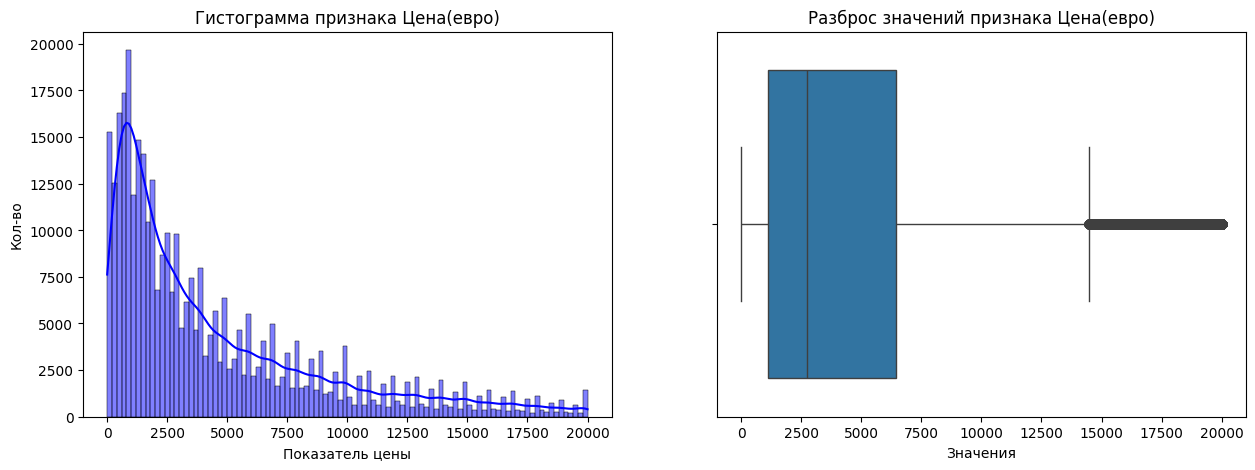

In [27]:
graph_num(df, 'price', 'Цена(евро)', 'Показатель цены', bins=100)

In [28]:
print(f"Кол-во аномально низких значений цены : {(df['price'] <= 500).sum()}")

Кол-во аномально низких значений цены : 39540


Рассмотрим как распределились значения ниже 1000 евро.

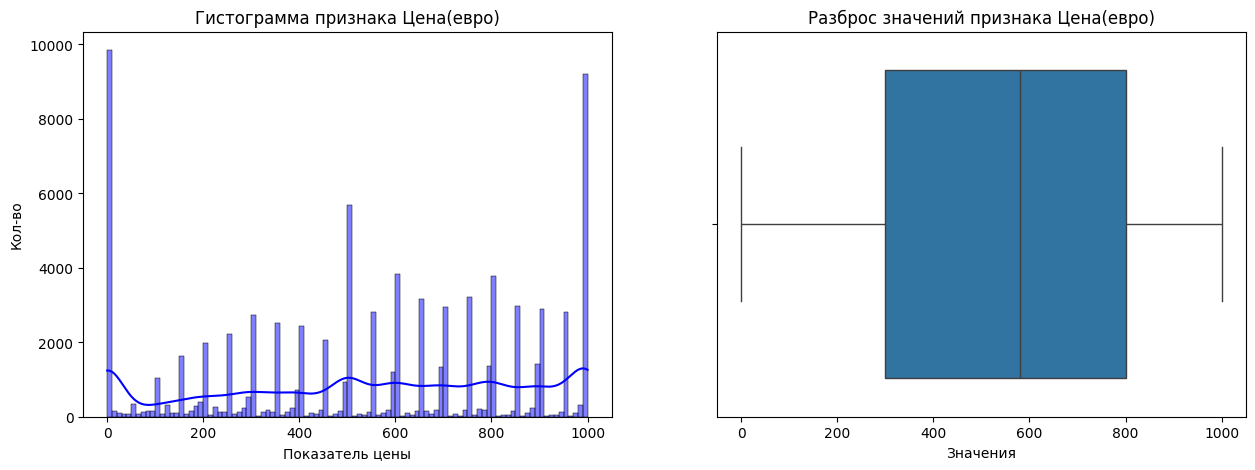

In [29]:
graph_num(df[df['price'] <= 1000], 'price', 'Цена(евро)', 'Показатель цены', bins=100)

Заменим подозрительные значения цены средним или медианой по модели автомобиля , для этого проанализируем значения и создадим словарь с моделями и их ценой для последующей замены.

In [30]:
pd.concat([df[df['price'] > 0].groupby('model')['price'].mean().astype(int).head(20).rename_axis('raw df').reset_index(name='models'), 
             df[df['price'] > 0].groupby('model')['price'].median().astype(int).head(20).rename_axis('raw df').reset_index(name='models')], axis=1)


raw df  models   raw df  models
0       100    1870      100    1225
1       145     879      145     600
2       147    2302      147    1999
3       156    1576      156    1294
4       159    7197      159    6450
5   1_reihe    1637  1_reihe     900
6       1er    9976      1er    9000
7       200    4093      200    3000
8   2_reihe    3189  2_reihe    2490
9      300c   10288     300c    9500
10  3_reihe    3280  3_reihe    1999
11      3er    5135      3er    3500
12  4_reihe    3502  4_reihe    2750
13      500    7803      500    7600
14  5_reihe    8089  5_reihe    6500
15      5er    6544      5er    5350
16      601    1882      601    1100
17  6_reihe    3460  6_reihe    2250
18      6er   13079      6er   14300
19      7er    6633      7er    5600

In [31]:
model_price_avg = df[df['price'] > 0].groupby('model')['price'].median().astype(int)
model_price_avg

model
100         1225
145          600
147         1999
156         1294
159         6450
           ...  
yaris       3290
yeti       12945
ypsilon      950
z_reihe     9850
zafira      2950
Name: price, Length: 250, dtype: int64

Для того что бы избежать большого кол-ва дубликатов в конце , добавим элемент небольшого разброса цены в диапазоне от (-30, 30).

In [32]:
def replace_price(row):
    if row['price'] <= 500:
        model = row['model']
        return (model_price_avg.get(model) + np.random.randint(-30, 30))
    else:
        return row['price']

df['price'] = df.apply(replace_price, axis=1)

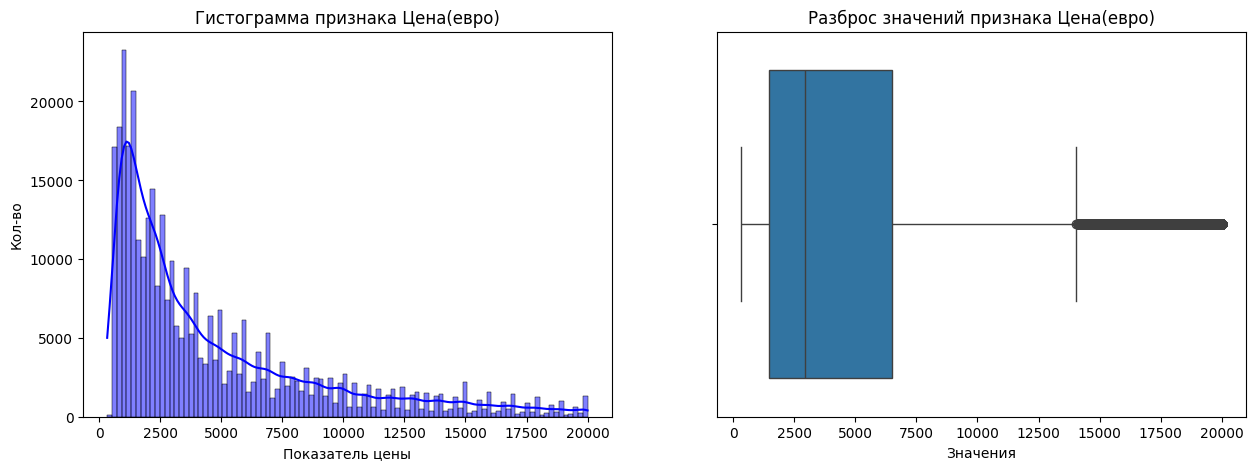

In [33]:
graph_num(df, 'price', 'Цена(евро)', 'Показатель цены', bins=100)

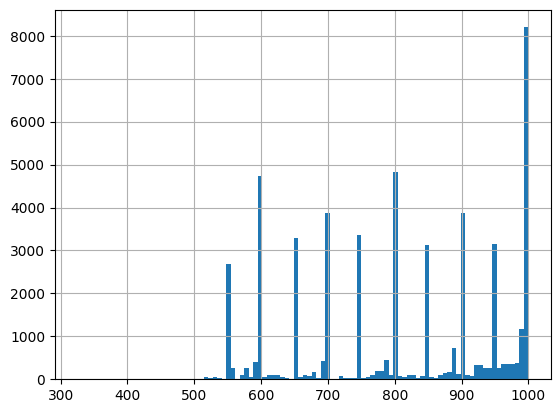

In [34]:
df[df.price <= 1000]['price'].hist(bins=100);

Видим что проблему с аномально низкими значениями удалось решить.

### Power

При рассмотрении отчета на этапе загрузки датасета , в переменной были обнаружены как аномально низки так и высокие аномальные значения для переменной отражающей кол-во лошадиных сил автомобиля.

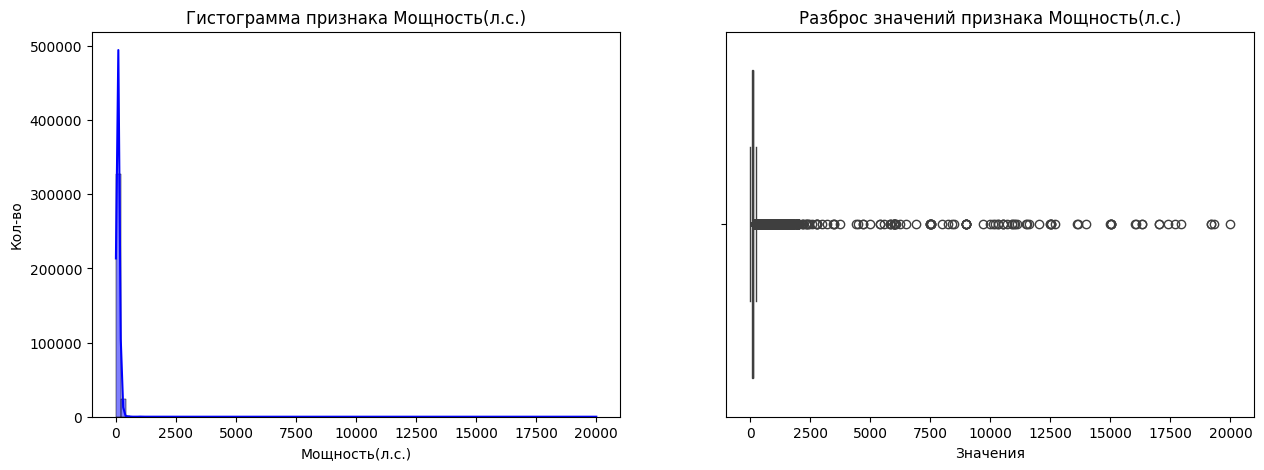

In [35]:
graph_num(df, 'power', 'Мощность(л.с.)', 'Мощность(л.с.)', bins=100)

Сделаем предположение что аномальные значения , это ошибка при заполнении вызванная добавлением дробной части к целому числу.

In [36]:
display(len(df[(df.power >= 1000) & (df.power <= 20000)]))
df[(df.power >= 1000) & (df.power <= 20000)]

307

datecrawled  price vehicletype  registrationyear gearbox  \
1804   2016-03-22 20:52:00   3200       small              2004  manual   
2087   2016-03-21 11:55:22   1184       sedan              1999     NaN   
5297   2016-03-29 19:44:48   1829       wagon              1999  manual   
7619   2016-04-02 19:25:25   1499       small              1999  manual   
7677   2016-04-02 11:48:54   1500       small              2000  manual   
...                    ...    ...         ...               ...     ...   
346728 2016-03-13 11:51:57   7500       sedan              2011  manual   
346812 2016-04-04 18:53:25    955       small              1999  manual   
349771 2016-03-07 21:36:19   1500         bus              2001  manual   
351308 2016-04-02 20:54:21  12500         NaN              2017  manual   
352072 2016-03-09 17:59:03   3482       other              1994     NaN   

        power    model  kilometer  registrationmonth  fueltype       brand  \
1804     1398  corolla       5000                  6    petrol      toyota   
2087     1799   vectra     150000                  1    petrol        opel   
5297     1001    astra     150000                  7    petrol        opel   
7619     7515     lupo     150000                  4    petrol  volkswagen   
7677     1400    other     150000                  0    petrol       honda   
...       ...      ...        ...                ...       ...         ...   
346728   1548   scenic      90000                  4    petrol     renault   
346812   1241  ypsilon     150000                  5    petrol      lancia   
349771   1001   zafira       5000                  7  gasoline        opel   
351308   2000    other      60000                  0  gasoline    chrysler   
352072   1103      3er     150000                  0       NaN         bmw   

       repaired datecreated  numberofpictures  postalcode            lastseen  
1804         no  2016-03-22                 0       22043 2016-03-22 21:43:26  
2087        yes  2016-03-21                 0        1723 2016-04-04 04:49:06  
5297        NaN  2016-03-29                 0       33154 2016-04-06 05:44:36  
7619        NaN  2016-04-02                 0       65830 2016-04-06 11:46:49  
7677        NaN  2016-04-02                 0       21509 2016-04-04 09:15:26  
...         ...         ...               ...         ...                 ...  
346728      NaN  2016-03-13                 0       24568 2016-04-06 15:17:39  
346812      yes  2016-04-04                 0       28259 2016-04-04 18:53:25  
349771       no  2016-03-07                 0       66117 2016-03-09 12:47:08  
351308       no  2016-04-02                 0       44145 2016-04-06 21:44:39  
352072      NaN  2016-03-09                 0       56235 2016-03-17 09:17:08  

[307 rows x 16 columns]

Применим функцию которая уменьшит порядок значения Л.С. в зависимости от значения.

In [37]:
df['power'] = df['power'].apply(power_change)

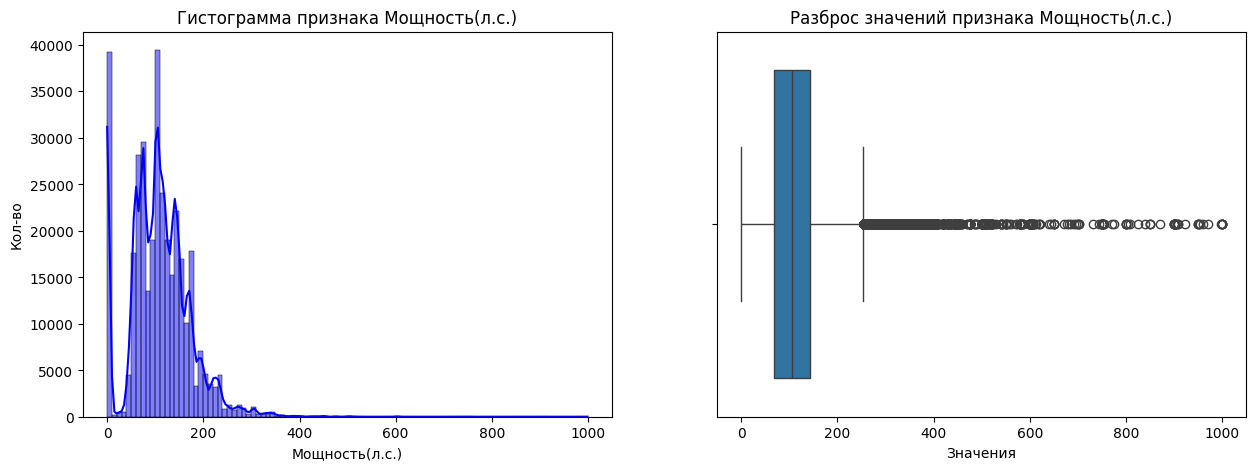

In [38]:
graph_num(df, 'power', 'Мощность(л.с.)', 'Мощность(л.с.)', bins=100)

Видим что удалось добиться приемлемого результата , сохранились незначительные выбросы их обработкой займемся ниже по ходу блока.

Обратимся к анализу нулевых значений в признаке.

In [39]:
print(f'Кол-во нулевых значений : {(df.power == 0).sum()}')
print(f'Процентное соотношение нулевых значений : {(df.power == 0).sum() / len(df)*100:.2f}%')


Кол-во нулевых значений : 38958
Процентное соотношение нулевых значений : 11.06%


Воспользуемся аналогичным методом замены примененным нами при обработке переменной *price* , а именно заменим нулевые значения Л.С. медианным значением по моделям авто.

In [40]:
model_power_avg = df[df['power'] > 0].groupby('model')['power'].median().astype(int)
model_power_avg

model
100        133
145        103
147        120
156        150
159        170
          ... 
yaris       75
yeti       110
ypsilon     60
z_reihe    170
zafira     125
Name: power, Length: 249, dtype: int64

In [41]:
def replace_power(row):
    power = row['power']
    
    if pd.isna(power) or power < 50:
        model = row['model']
        avg_power = model_power_avg.get(model)
        
        if avg_power is not None:
            return avg_power + np.random.randint(-5, 6)
        else:
            return np.random.randint(80, 151)
    else:
        return power

df['power'] = df.apply(replace_power, axis=1)

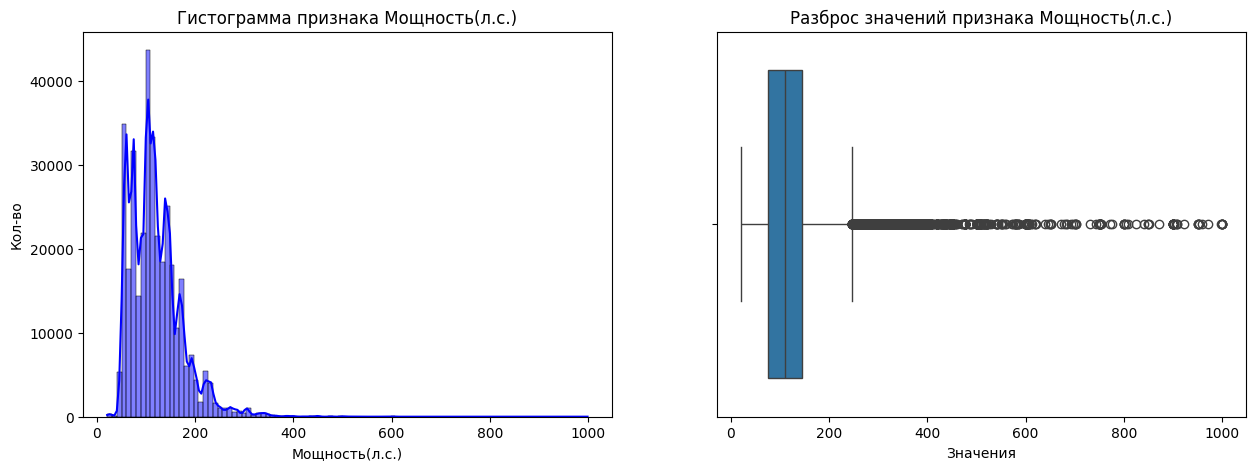

In [42]:
graph_num(df, 'power', 'Мощность(л.с.)', 'Мощность(л.с.)', bins=100)

In [43]:
df['power'].value_counts().sort_index()

power
21     45
22     39
23     48
24     30
25     35
       ..
953     1
960     1
971     1
998     1
999     5
Name: count, Length: 475, dtype: int64

Удалим выбросы выше логически приемлемого значения в 400 л.с.

In [44]:
trash_pw = df[df['power'] >= 400]

In [45]:
df = df.drop(trash_pw.index).reset_index(drop=True)

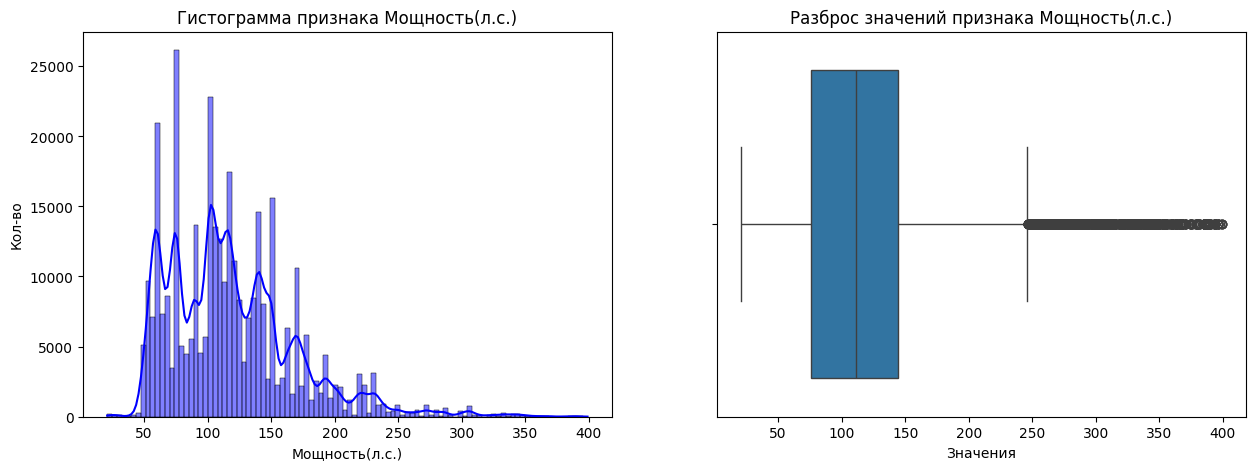

In [46]:
graph_num(df, 'power', 'Мощность(л.с.)', 'Мощность(л.с.)', bins=100)

В целом удалось привести признак *power* к надлежащему виду.

### Registrationyear

Посмотрим на аномальные значения в столбце *Registrationyear*

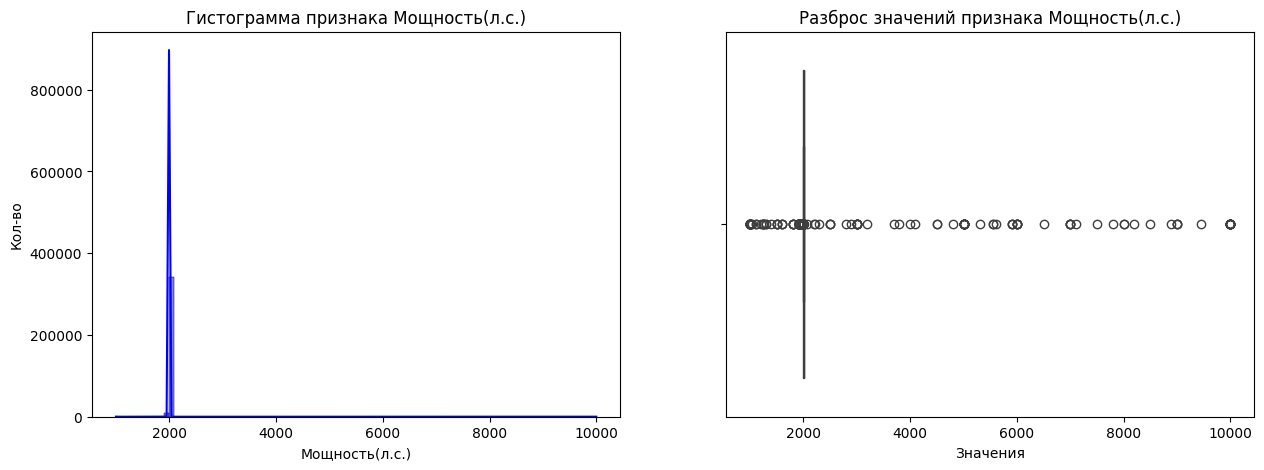

In [47]:
graph_num(df, 'registrationyear', 'Мощность(л.с.)', 'Мощность(л.с.)', bins=100)

In [48]:
df['registrationyear'].describe()

count    351664.00000
mean       2004.03393
std          79.88820
min        1000.00000
25%        1999.00000
50%        2003.00000
75%        2008.00000
max        9999.00000
Name: registrationyear, dtype: float64

Видим распределение начинающиеся с значения в 1000 и заканчивающиеся 9999 , что очевидно является аномалией для признака отражающего год производства автомобиля.

Определим нижнею границу признака в 1970 , а так же опираясь на данные представленные выше о том что датасет отражает авторынок за **2016** год , создадим срез для удаления из основного набора данных.

In [49]:
trash_year = pd.concat([df[df['registrationyear'] <= 1970], df[df['registrationyear'] > 2016]])
trash_year

datecrawled  price vehicletype  registrationyear gearbox  \
15     2016-03-11 21:39:15    971       small              1910     NaN   
624    2016-03-18 12:43:41  12000       sedan              1969  manual   
1323   2016-04-03 19:53:44    650         NaN              1970     NaN   
1782   2016-04-03 21:49:57  12800       coupe              1965  manual   
1832   2016-03-31 19:50:00   1200         NaN              1970  manual   
...                    ...    ...         ...               ...     ...   
351408 2016-03-11 15:49:51   3600         NaN              2017  manual   
351436 2016-03-29 16:47:29   1000         NaN              2017  manual   
351499 2016-03-17 00:56:26   2140         NaN              2018  manual   
351549 2016-03-25 09:37:59   1250         NaN              2018     NaN   
351585 2016-03-05 14:55:29   5000         NaN              2017  manual   

        power     model  kilometer  registrationmonth  fueltype  \
15         56        ka       5000                  0    petrol   
624       140  s_klasse      80000                  3    petrol   
1323      120     other     100000                  5       NaN   
1782       90     other     100000                  8    petrol   
1832       43    kaefer     150000                  5    petrol   
...       ...       ...        ...                ...       ...   
351408     86   transit     150000                  5  gasoline   
351436    101        a4     150000                  9       NaN   
351499     80    fiesta     150000                  6       NaN   
351549     61     corsa     150000                  0    petrol   
351585    120     other     150000                  7       NaN   

                brand repaired datecreated  numberofpictures  postalcode  \
15               ford      NaN  2016-03-11                 0       24148   
624     mercedes_benz       no  2016-03-18                 0       46286   
1323          trabant      NaN  2016-04-03                 0        9337   
1782             ford       no  2016-04-03                 0       12049   
1832       volkswagen      NaN  2016-03-31                 0       90459   
...               ...      ...         ...               ...         ...   
351408           ford      NaN  2016-03-11                 0       32339   
351436           audi      NaN  2016-03-29                 0       38315   
351499           ford       no  2016-03-17                 0       44866   
351549           opel      NaN  2016-03-25                 0       45527   
351585        citroen      yes  2016-03-05                 0       15518   

                  lastseen  
15     2016-03-19 08:46:47  
624    2016-04-05 22:16:44  
1323   2016-04-05 20:45:24  
1782   2016-04-05 23:15:21  
1832   2016-04-06 14:17:55  
...                    ...  
351408 2016-03-12 05:45:02  
351436 2016-04-06 02:44:27  
351499 2016-03-29 15:45:04  
351549 2016-04-06 07:46:13  
351585 2016-04-05 11:48:09  

[15871 rows x 16 columns]

In [50]:
trash_year['registrationyear'].value_counts().sort_index()

registrationyear
1000    33
1001     1
1039     1
1111     2
1200     1
        ..
8500     1
8888     1
9000     3
9450     1
9999    19
Name: count, Length: 97, dtype: int64

In [51]:
df = df.drop(trash_year.index).reset_index(drop=True)

In [52]:
print(f'Размерность базового датасета : {len(check)}')
print(f'Размерность датасета после обработки : {len(df)}')

Размерность базового датасета : 354369
Размерность датасета после обработки : 335793


### Обработка категориальных переменных.

#### fueltype

In [53]:
df.fueltype.value_counts()

fueltype
petrol      207952
gasoline     96068
lpg           5117
cng            541
hybrid         222
other          158
electric        86
Name: count, dtype: int64

In [54]:
print(f'Кол-во пропусков в переменной fueltype : {df.fueltype.isna().sum()}')


Кол-во пропусков в переменной fueltype : 25649


Так же изучив открытые источники , мы нашли информацию о том что такие значения переменной как : *gasoline , petrol* отражают бензиновый тип двигателя , разница лишь в том что в разных странах приняты разные обозначения.

Так как достоверно установить тип двигателя не представляется возможным , создадим заглушку в виде значения *UnK*.

In [55]:
df['fueltype'] = df['fueltype'].replace({'gasoline': 'petrol'})

In [56]:
df['fueltype'] = df['fueltype'].fillna('UnK')

In [57]:
df.fueltype.value_counts()

fueltype
petrol      304020
UnK          25649
lpg           5117
cng            541
hybrid         222
other          158
electric        86
Name: count, dtype: int64

In [58]:
print(f'Кол-во пропусков в переменной fueltype : {df.fueltype.isna().sum()}')

Кол-во пропусков в переменной fueltype : 0


#### vehicletype   gearbox  repaired

В виду низкой корреляции с целевой переменной и не возможности достоверного заполнения пропусков без искажения данных , так же заполним пропущенные значения в этих переменных заглушкой *UnK*

In [59]:
columns_to_fill = ['vehicletype', 'gearbox', 'repaired']
df[columns_to_fill] = df[columns_to_fill].fillna('UnK')

#### Удаление не информативных и дублирующих переменных.

Так же непосредственно перед переходом к обучению модели , избавимся от признаков не имеющих отношения к целевому признаку , а именно таких как : данные отражающие даты выгрузки и регистрации , кол-во фотографий, и месяц регистрации авто.

In [60]:
df = df.drop(['datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'lastseen'], axis=1)

### Проверка на появление потенциальных дубликатов в следствии обработки признаков.

In [61]:
print(f'Кол-во образовавшихся дубликатов : {df.duplicated().sum()}')

Кол-во образовавшихся дубликатов : 19784


В следствии выполненной обработки данных , образовались дубликаты , для избежания переобучения модели и повышения её репрезентативности удалим их из обучающего датасета.

In [62]:
df.drop_duplicates(inplace=True)

In [63]:
print(f'Размерность базового датасета : {len(check)}')
print(f'Размерность датасета после обработки : {len(df)}')

Размерность базового датасета : 354369
Размерность датасета после обработки : 316009


### Проверка результатов проведенной работы.

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316009 entries, 0 to 335792
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             316009 non-null  int64 
 1   vehicletype       316009 non-null  object
 2   registrationyear  316009 non-null  int64 
 3   gearbox           316009 non-null  object
 4   power             316009 non-null  int64 
 5   model             316009 non-null  object
 6   kilometer         316009 non-null  int64 
 7   fueltype          316009 non-null  object
 8   brand             316009 non-null  object
 9   repaired          316009 non-null  object
 10  postalcode        316009 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 28.9+ MB


In [65]:
ProfileReport(df, title="Profiling Report", minimal=False, progress_bar=False)

100%|██████████| 11/11 [00:01<00:00,  5.54it/s]


Как видим из отчета удалось добиться относительно высокого качества исходного датасета , и потерять не так много даннах.

### Вывод

- В ходе проделанной работы нам удалось решить проблему аномальных значений и пропусков в исходных признаках *'price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model','kilometer', 'fueltype', 'brand', 'repaired', 'postalcode'*

- Избавится от неинформативных признаков : *'datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'lastseen'*

- А так же решить проблему с образовавшимися дубликатами.

## Корреляционный анализ и VIF-значения.

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer', 'postalcode']


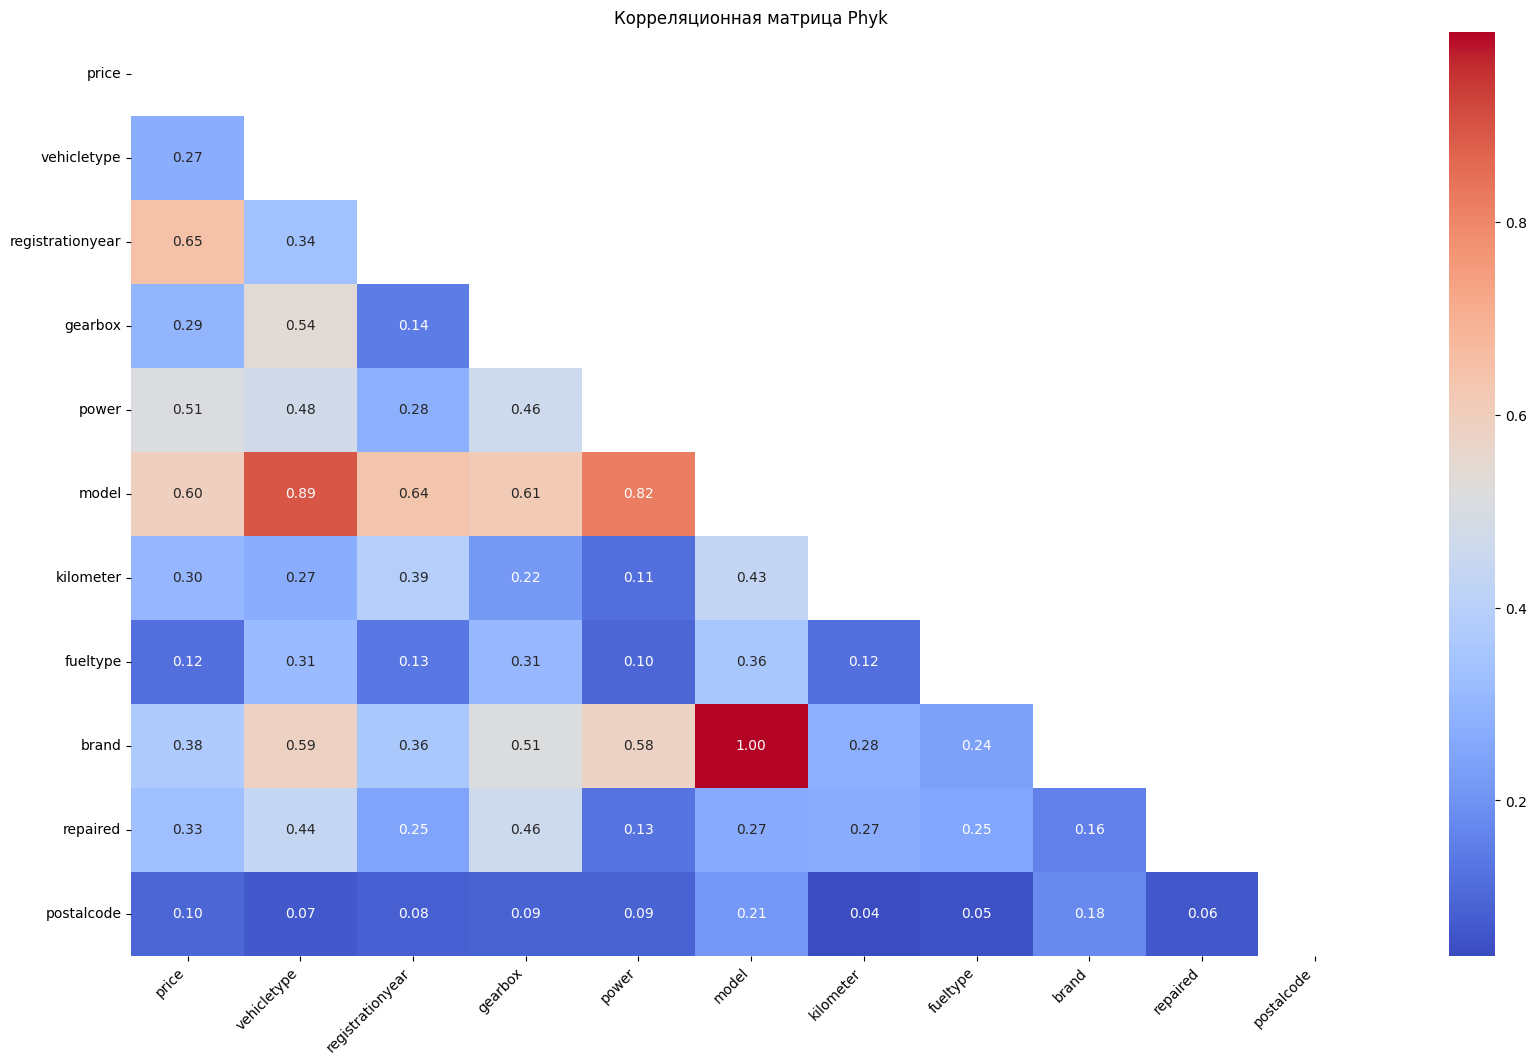

In [66]:
phik_matrix = df.phik_matrix()
tri = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(20, 12))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=tri);
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.title("Корреляционная матрица Phyk")
plt.show()

In [67]:
num_cols = df.select_dtypes(include='number').columns

vif_data = pd.DataFrame()
vif_data["feature"] = num_cols

vif_data["VIF"] = [variance_inflation_factor(df[num_cols].assign(const=1).values, i) 
                  for i in range(len(num_cols))]

print(vif_data)

            feature       VIF
0             price  2.063153
1  registrationyear  1.335122
2             power  1.526997
3         kilometer  1.293181
4        postalcode  1.006934


### Вывод 

- В ходе проведенного анализа удалось заметить 100 корреляцию между переменными **model и brand** , на этапе обучения моделей исключим из обучения признак *brand*.

- Так же ввиду низкой корреляции исключим переменную **postalcode** на этапе обучения моделей.

- Мультиколлинеарности числовых признаков обнаружить не удалось.

## Обучение моделей.

### Подготовка выборок.

In [68]:
X = df.drop(('price'), axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS) 
                                                
X_train.head(15)

vehicletype  registrationyear gearbox  power     model  kilometer  \
234890  convertible              2010  manual    140     other     150000   
173918          bus              2012  manual    125     altea      50000   
87189         small              2012  manual     75    twingo      80000   
19576         small              2004  manual     75      polo     150000   
292274        sedan              1996    auto    280  e_klasse     150000   
93938           UnK              1980  manual    117     other      90000   
299336        sedan              2006  manual    150      golf     125000   
58879         sedan              2007  manual    120     bravo     125000   
30655   convertible              1990     UnK    145       3er     125000   
61418           UnK              2016  manual     88     other     150000   
72888         other              2001  manual    105      golf     125000   
96289         small              1997  manual     63     corsa     150000   
107964        wagon              2012  manual    194  insignia      80000   
269549        small              2006  manual    101    fiesta      90000   
115196          UnK              2000     UnK    126   6_reihe     125000   

       fueltype           brand repaired  postalcode  
234890   petrol        chrysler       no       86836  
173918   petrol            seat       no       17373  
87189    petrol         renault       no       59964  
19576    petrol      volkswagen       no       24969  
292274   petrol   mercedes_benz      yes       92546  
93938    petrol  sonstige_autos       no        7778  
299336   petrol      volkswagen       no       58640  
58879    petrol            fiat       no       88239  
30655       UnK             bmw       no       81379  
61418       UnK         citroen      UnK       80634  
72888    petrol      volkswagen       no       85055  
96289    petrol            opel      yes       66111  
107964   petrol            opel      UnK       36326  
269549   petrol            ford       no       50829  
115196      UnK           mazda      UnK       44623

### Определение базовых шагов *пайплайна*

Разделим признаки на несколько групп для последующего применения кодировщиков в процессе работы пайплайна.

In [69]:
num_cols = ['registrationyear', 'power', 'kilometer']
cat_cols = ['vehicletype', 'gearbox', 'fueltype', 'repaired']
big_cat = ['model']

Создадим метрику RMSE.

In [70]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)  

In [71]:
# Создадим заглущки , а параметры будем перебирать в models
numeric_transformer = Pipeline([
    ('scaler', 'passthrough'),  
    ('preprocessor', None)      
])

cat_transformer = Pipeline([
    ('encoder', 'passthrough'),  
    ('preprocessor', None)      
])

big_transformer = Pipeline([
    ('encoder', 'passthrough'),  
    ('preprocessor', None) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', cat_transformer, cat_cols), 
        ('big', big_transformer, big_cat)
    ],
    remainder='drop',
    transformer_weights=None)

### Линейные модели

In [72]:
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'preprocessor__cat__encoder': [OneHotEncoder(handle_unknown='ignore', drop='first')],
            'preprocessor__big__encoder': [OneHotEncoder(handle_unknown='ignore', drop='first')],
            'regressor__fit_intercept': [True, False]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=RS),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'preprocessor__cat__encoder': [OneHotEncoder(handle_unknown='ignore', drop='first')],
            'preprocessor__big__encoder': [OneHotEncoder(handle_unknown='ignore', drop='first')],
            'regressor__alpha': [0.01, 0.1, 1.0], 
            'regressor__l1_ratio': [0.2, 0.5, 0.8],   
            'regressor__max_iter': [1000],
            # 'regressor__tol': [1e-4, 1e-5],
            'regressor__selection': ['cyclic', 'random']
        }
    },
}

In [73]:
%%time
# KNN выдавал предупреждение разных версий
warnings.filterwarnings("ignore", category=FutureWarning) 
results = {}
for name, config in models.items():

    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    # Перебор по GridSearch
    grid = GridSearchCV(
        pipeline,
        config['params'],
        scoring=rmse_scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    results[name] = {
        'best_model': grid.best_estimator_,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'mean_fit_time': grid.cv_results_['mean_fit_time'].mean(), 
        'mean_score_time': grid.cv_results_['mean_score_time'].mean() 
         }
    
    print(f"{name} completed. Best Score: {grid.best_score_:.4f}")
# for name, res in results.items():
#     print(f"{name}:")
#     print(f"Test Score: {res['best_score']:.4f}\n")
#     print(f"Best Params: {res['best_params']}\n")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
LinearRegression completed. Best Score: -2597.6298
Fitting 5 folds for each of 54 candidates, totalling 270 fits
ElasticNet completed. Best Score: -2673.5590
CPU times: total: 53.9 s
Wall time: 2min 3s


### KNN Модель

In [74]:
models = {
        'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'preprocessor__cat__encoder': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                                           OneHotEncoder(handle_unknown='ignore', drop='first')],
                                            
            'preprocessor__big__encoder': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
                                           
            'regressor__n_neighbors': [3, 5, 7, 9],
            'regressor__weights': ['uniform', 'distance']
        }
    },
}

In [75]:
%%time
for name, config in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    # Использование RandomizedSearchCV вместо GridSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        config['params'],
        n_iter=5,  
        scoring=rmse_scorer,
        cv=2,
        n_jobs=-1,
        verbose=1,
        random_state=RS  
    )
    
    random_search.fit(X_train, y_train)
    
    results[name] = {
        'best_model': random_search.best_estimator_,
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'mean_fit_time': random_search.cv_results_['mean_fit_time'].mean(), 
        'mean_score_time': random_search.cv_results_['mean_score_time'].mean()
    }
    
    print(f"{name} completed. Best Score: {random_search.best_score_:.4f}")

# for name, res in results.items():
#     print(f"{name}:")
#     print(f"Test Score: {res['best_score']:.4f}\n")
#     print(f"Best Params: {res['best_params']}\n")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
KNeighborsRegressor completed. Best Score: -1858.5575
CPU times: total: 1.88 s
Wall time: 2min 9s


### LightGBM модель

In [76]:
models = {
    'LGBMRegressor': {
        'model': LGBMRegressor(random_state=42, verbose=-1), 
        'params': {
            'preprocessor__num__scaler':  [StandardScaler(), MinMaxScaler(), RobustScaler()],
            'preprocessor__cat__encoder': [
                                          OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                                          OneHotEncoder(handle_unknown='ignore', drop='first')],
            'preprocessor__big__encoder': [
                                          CatBoostEncoder(sigma=0.1, a=1.0, handle_unknown='value', handle_missing='value'),
                                          OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
            
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [3, 5, 7],
            'regressor__num_leaves': [15, 31, 63],
            'regressor__min_child_samples': [10, 20]
        }
    },
    
}

In [77]:
%%time
for name, config in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    # Использование RandomizedSearchCV вместо GridSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        config['params'],
        n_iter=50,  
        scoring=rmse_scorer,
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=RS  
    )
    
    random_search.fit(X_train, y_train)
    
    results[name] = {
        'best_model': random_search.best_estimator_,
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'mean_fit_time': random_search.cv_results_['mean_fit_time'].mean(), 
        'mean_score_time': random_search.cv_results_['mean_score_time'].mean()
    }
    
    print(f"{name} completed. Best Score: {random_search.best_score_:.4f}")

for name, res in results.items():
    print(f"{name}:")
    print(f"Test Score: {res['best_score']:.4f}\n")
    print(f"Best Params: {res['best_params']}\n")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
LGBMRegressor completed. Best Score: -1668.7212
LinearRegression:
Test Score: -2597.6298

Best Params: {'preprocessor__big__encoder': OneHotEncoder(drop='first', handle_unknown='ignore'), 'preprocessor__cat__encoder': OneHotEncoder(drop='first', handle_unknown='ignore'), 'preprocessor__num__scaler': MinMaxScaler(), 'regressor__fit_intercept': True}

ElasticNet:
Test Score: -2673.5590

Best Params: {'preprocessor__big__encoder': OneHotEncoder(drop='first', handle_unknown='ignore'), 'preprocessor__cat__encoder': OneHotEncoder(drop='first', handle_unknown='ignore'), 'preprocessor__num__scaler': RobustScaler(), 'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.8, 'regressor__max_iter': 1000, 'regressor__selection': 'cyclic'}

KNeighborsRegressor:
Test Score: -1858.5575

Best Params: {'regressor__weights': 'uniform', 'regressor__n_neighbors': 5, 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__cat__encoder': OneHotE

### Сборный анализ моделей и метрик.

In [78]:
df_scores = pd.DataFrame.from_dict(
    {name: [res['best_score'], res['mean_fit_time'], res['mean_score_time']]    for name, res in results.items()},
    orient='index',
    columns=['best_score', 'mean_fit_time', 'mean_score_time']
).reset_index()

In [79]:
for col in df_scores.select_dtypes('number'):
    df_scores[col] = df_scores[col].round(2)

In [80]:
df_scores.columns = ['models', 'score', 'fit_time', 'predict_time']

In [81]:
df_scores['score'] = df_scores['score'] * -1

In [86]:
df_scores.sort_values('score', ascending=True)

models    score  fit_time  predict_time
3        LGBMRegressor  1668.72      8.90          0.29
2  KNeighborsRegressor  1858.56      0.25        127.71
0     LinearRegression  2597.63      6.30          0.16
1           ElasticNet  2673.56      6.84          0.16

Попытаемся создать оценочную метрику на основании всех полученных данных , воспользуемся формулой *RMSE×log(Tpredict+Ttrain)*

In [91]:
df_scores['totel_metric'] = (df_scores['score'] * np.log(df_scores['fit_time']+df_scores['predict_time'])).round(2)

In [92]:
df_scores.sort_values('totel_metric', ascending=True)

models    score  fit_time  predict_time  totel_metric
3        LGBMRegressor  1668.72      8.90          0.29       3701.41
0     LinearRegression  2597.63      6.30          0.16       4846.21
1           ElasticNet  2673.56      6.84          0.16       5202.51
2  KNeighborsRegressor  1858.56      0.25        127.71       9017.21

### Проверка на тестовых данных и обзор важности фичей.

Сохранение модели.

In [83]:
best_model = results['LGBMRegressor']['best_model']
best_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('preprocessor',
                                                                   None)]),
                                                  ['registrationyear', 'power',
                                                   'kilometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('preprocessor',
                                                                   None)]),
                                                  ['vehicletype', 'gearbox',
                                                   'fueltype', 'repaired']),
                                                 ('big',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('preprocessor',
                                                                   None)]),
                                                  ['model'])])),
                ('regressor',
                 LGBMRegressor(max_depth=7, n_estimators=200, num_leaves=63,
                               random_state=42, verbose=-1))])

In [84]:
y_pred = best_model.predict(X_test)

C:\Users\para\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [112]:
print(f"Метрика RMSE на тестовых данных : {rmse(y_test, y_pred).round(2)}")

Метрика RMSE на тестовых данных : 1644.49


**Обзор важности признаков**

In [113]:
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

importances = best_model.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance_df

feature  importance
7             big__model        3334
1             num__power        3023
0  num__registrationyear        2698
3       cat__vehicletype        1167
2         num__kilometer        1072
6          cat__repaired         430
4           cat__gearbox         354
5          cat__fueltype         117

In [114]:
feature_importance_df_sorted = feature_importance_df.sort_values('importance', ascending=True)

top_features = feature_importance_df_sorted.tail(20)

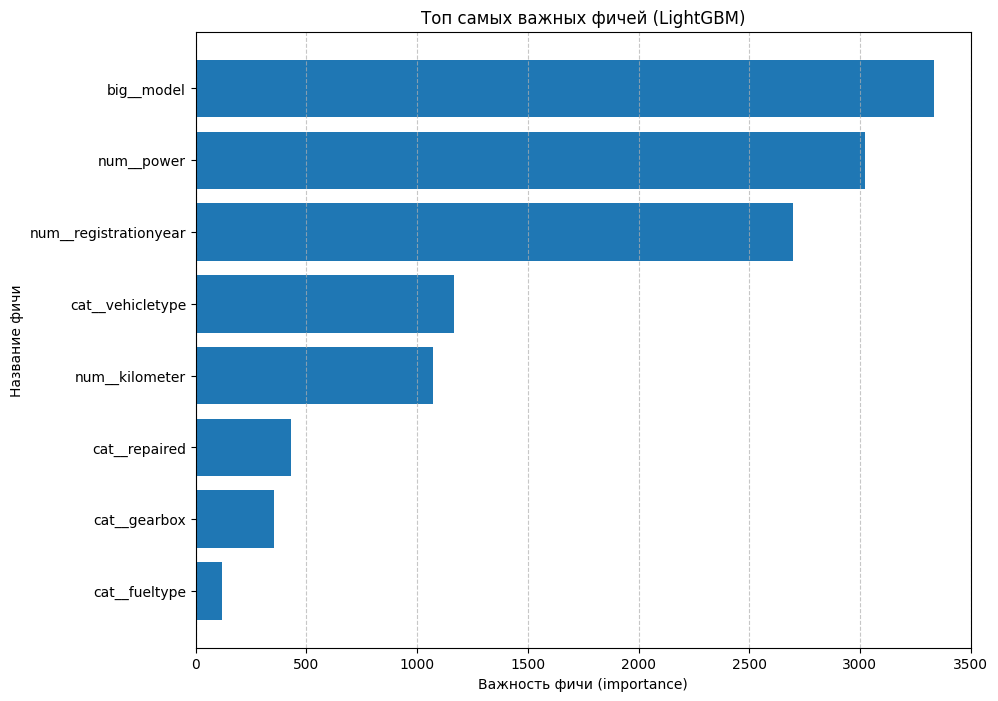

In [116]:
plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Важность фичи (importance)')
plt.ylabel('Название фичи')
plt.title('Топ самых важных фичей (LightGBM)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Вывод

- В ходе построения и использования пайплайна мы протестировали различные модели такие как : **LinearRegression, KNN , LightGBM**.

- Для оценки качества моделей мы использовали метрику RMSE , лучшей результат показала модель LightGBM набрав 1700 пунктов.

- Так же получив данные о времени обучения и предсказания , нами была построена кастомная метрика оценки эффективности модели по принципу *RMSE×log(Tpredict+Ttrain)*. Где модель LightGBM так же показала лучший результат.

- Проверка важности признаков показала что самыми важными факторами при формировании цены являются **model, power, registrationyear** , что в целом полностью соответствует логике рынка автомобилей.

## Вывод по исследованию.

К нам обратился заказчик «Не бит, не крашен» с задачей построить модель МО для предсказания цены автомобиля на основе имеющихся у них данных , вот чего нам удалось достичь по ходу исследования :

- Мы загрузили присланные заказчиком данные и провели первичное ознакомление. По результатам которого мы обнаружили множественные дефекты в данных , такие как пропуски и аномальные значения в таких признаках как : **'price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model','kilometer', 'fueltype', 'brand', 'repaired'**

- На этапе предобработки данных нам удалось , повысить качество данных , заполнил пробелы в числовых данных медианами значениями по маркам автомобилей , а так же применили заглушку *UnK* для категориальных признаков. Часть данных была удалена сократив изначальный размер датасета с 354369
до 316040. Так же мы удалили из обучения неинформативные переменные такие как : **'datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'lastseen'** , тем самым еще улучшив структуру данных.

- Проведя корреляционный анализ мы еще сократили список признаков переданных на обучение , удалив переменную **brand** имеющую 100% корреляцию с **model** , а так же **postalcode** ввиду низкой корреляции и неинформативности.

- На этапе обучения мы перешли к построению и запуску пайплайна с ходе которого мы провели тестирование нескольких моделей для сравнения методами крос-валидвации. По заданию от заказчика мы протестировали несколько моделей таких как **LinearRegression, KNN , LightGBM** с использованием метрики RMSE , в ходе сравнительного анализа удалось достичь следующих результатов : **LGBMRegressor     | 1700.9815302376/7** **KWeightbonRegressor | 1847.318536698128**  **LinearRegression  | 2592.738163218919**  **ElasticNet        | 2667.835637698917**

- Лучшей моделью оказалась модель градиентного бустинга LGBM , её и принято передать заказчику для внедрения в сервис.